# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value" ICML 2023 , using pyDVL.
https://proceedings.mlr.press/v202/kwon23e.html

The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
import sklearn as sk

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std
from pydvl.value.result import ValuationResult

In [3]:
from sklearn import datasets

In [4]:
sklearn_dataset = sk.datasets.load_diabetes()
data = Dataset.from_sklearn(sklearn_dataset)
model = DecisionTreeRegressor()
utility = Utility(model, data)

In [5]:
oob_values = compute_data_oob(utility, n_est=1000, max_samples=0.95, progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

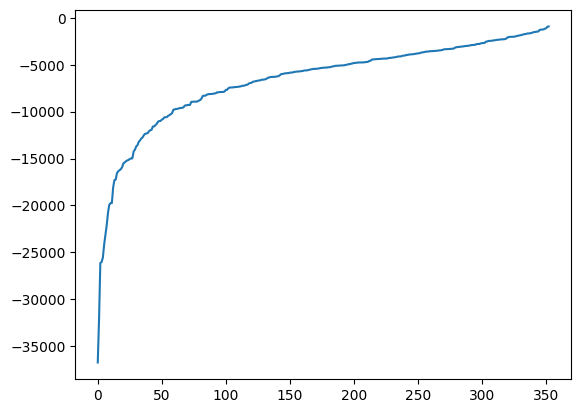

In [6]:
oob_values.sort(key='value')
plt.plot(np.arange(len(oob_values.values)), oob_values.values);

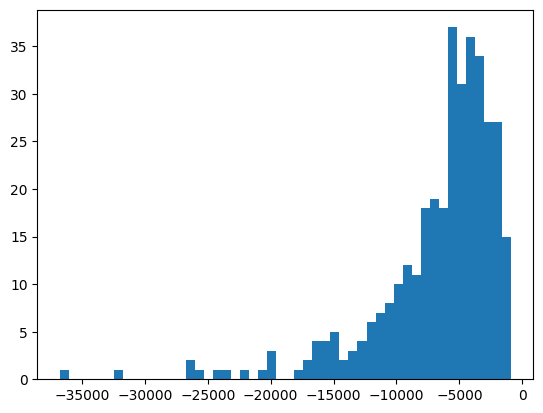

In [7]:
plt.hist(oob_values.values, bins=50);

## Variance

The variance it the weak learner variance. It is computed with Welford's online algorithm.

In [8]:
import pandas as pd

In [9]:
plot_list = [(a,b) for a,b in zip(oob_values.values, oob_values.variances)]
plot_list = pd.DataFrame(plot_list).sample(100).sort_values(by=0).values
yerr = [x[1]**2 for x in plot_list]


The folowing figure clearly depticts the problem of unbounded utility function. 

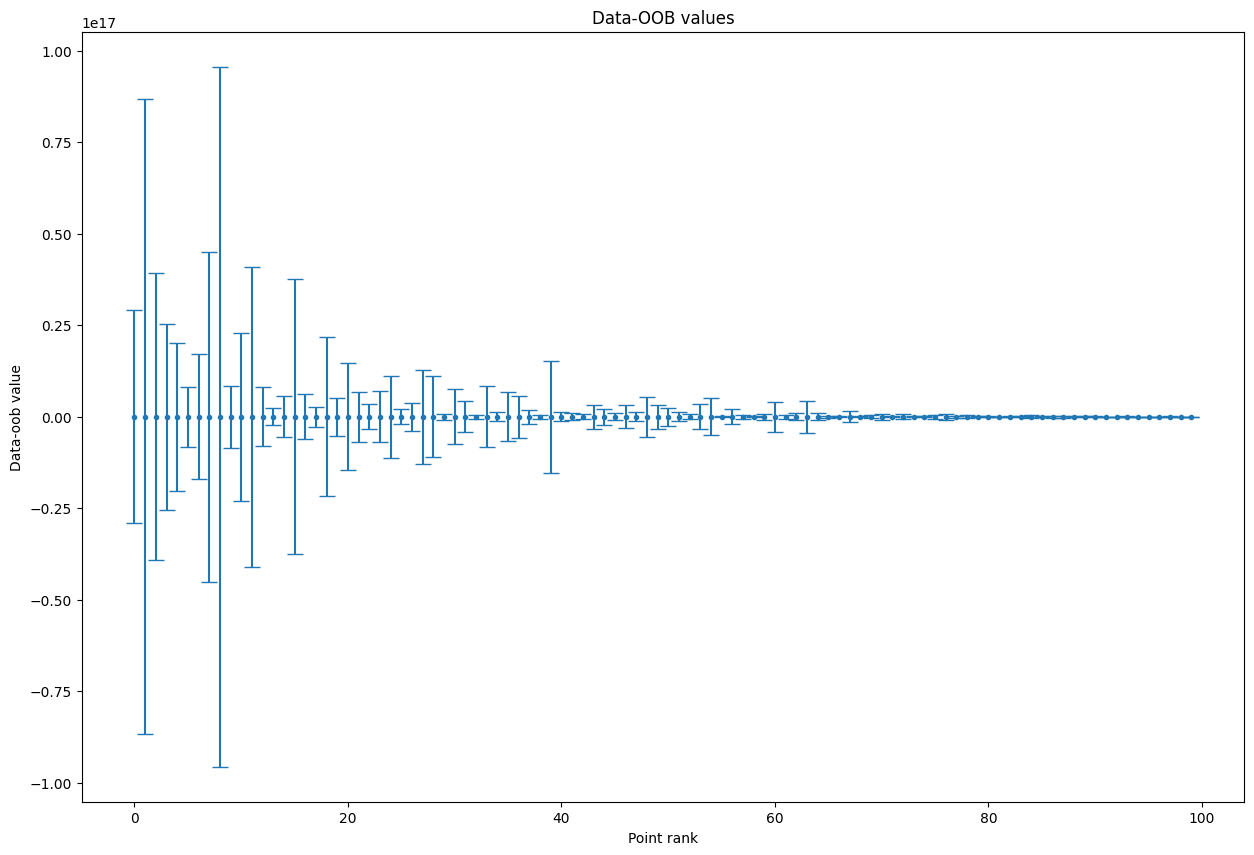

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,10])
ax.errorbar(x=np.arange(len(yerr)), y=[x[0] for x in plot_list], yerr=yerr, fmt= ".",  capsize=6);
plt.title("Data-OOB values");
ax.set_ylabel("Data-oob value");
ax.set_xlabel("Point rank");

# Point removal experiments

The standard procedure for the evaluation of data valuation schemes is the point removal experiment. The objective is to measure the evolution of performance when the best/worst points are removed from the training set. 

In [11]:

mean_colors = ["dodgerblue", "indianred", "limegreen", "darkorange", "darkorchid"]
shade_colors = ["lightskyblue", "firebrick", "seagreen", "gold", "plum"]

In [12]:
all_best_scores = []
all_worst_scores = []

removal_percentages = np.arange(0, 0.99, 0.01)

for i in range(5):
    for method_name in ["Random","oob"]:
        if method_name == "Random":
            values = ValuationResult.from_random(size=len(utility.data))
        else:
            values = compute_data_oob(utility, n_est=300, max_samples=0.4, progress=True)

        best_scores = compute_removal_score(
            u=utility,
            values=values,
            percentages=removal_percentages,
            remove_best=True,
        )
        best_scores["method_name"] = method_name
        all_best_scores.append(best_scores)
        
        worst_scores = compute_removal_score(
            u=utility,
            values=values,
            percentages=removal_percentages,
            remove_best=False,
        )
        worst_scores["method_name"] = method_name
        all_worst_scores.append(worst_scores)

best_scores_df = pd.DataFrame(all_best_scores)
worst_scores_df = pd.DataFrame(all_worst_scores)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

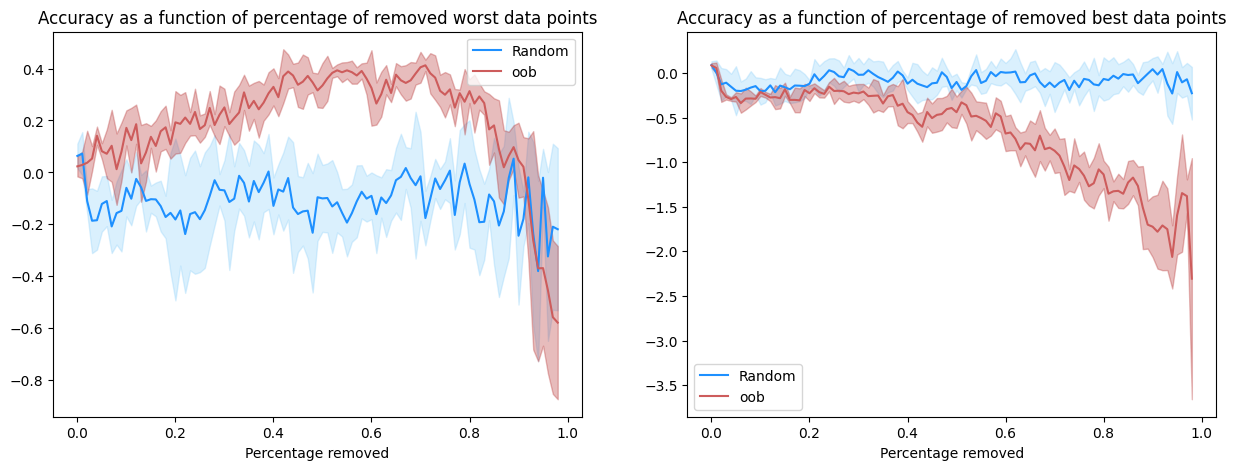

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,5])

for i, method_name in enumerate(["Random","oob"]):
    shaded_mean_std(
        best_scores_df[best_scores_df["method_name"] == method_name].drop(
            columns=["method_name"]
        ),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Percentage removed",
        #ylabel=utility.scorer._name.capitalize(),
        label=method_name,
        title="Accuracy as a function of percentage of removed best data points",
        ax=ax[1],
    )
    shaded_mean_std(
        worst_scores_df[worst_scores_df["method_name"] == method_name].drop(
            columns=["method_name"]
        ),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Percentage removed",
        #ylabel=utility.scorer._name.capitalize(),
        label=method_name,
        title="Accuracy as a function of percentage of removed worst data points",
        ax=ax[0],
    )
ax[0].legend();
ax[1].legend();
plt.show();